In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals
import os
import datetime
import random
import glob
import shutil
import pathlib
import seaborn as sns
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt

!pip install -q tf-nightly-gpu-2.0-preview==2.0.0.dev20190607
!pip install -q -U tb-nightly
%load_ext tensorboard 

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorboard.plugins.hparams import api_pb2
from tensorboard.plugins.hparams import summary as hparams_summary
from google.protobuf import struct_pb2
keras = tf.keras
AUTOTUNE = tf.data.experimental.AUTOTUNE

from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, accuracy_score, precision_score, confusion_matrix, roc_curve, roc_auc_score

from google.colab import drive
drive.mount('/content/gdrive')


#-----get data from github
!git clone https://github.com/davordavidovic/lung_data.git

In [0]:
#-------------location of data---------------
DATA_DIR = './lung_data/_PROCESSED/'
BATCH_SIZE = 64
METHOD = 'patch'

#select image size and method here
IMG_SIZE = 96 if METHOD == 'patch' else 128 # All images will be resized to image size x image size

#getting the image paths for particular method. The directory structure is important here
#directories have to be labeled as below
def get_all_image_paths(dataset_frac=1.0, method='holistic'):
  df = pd.read_csv('{}labels_{}.csv'.format(DATA_DIR, method))
  df_cancer = df[df.cancer == 1]
  df_non_cancer = df[df.cancer == 0]
  
  if method=='holistic':
    df_non_cancer = df[df.cancer == 0].sample(frac=0.33) #sample only a fraction of non_cancer images
    df_cancer = df_cancer.sample(frac=dataset_frac)
    df_non_cancer = df_non_cancer.sample(frac=dataset_frac)
  
  
  print('Total cancer images:', len(df_cancer))
  print('Total non-cancer images:',len(df_non_cancer))
  

  #dataframe of all images
  df = pd.concat([df_cancer, df_non_cancer], ignore_index=True)

  #extracts paths to each image using its name
  all_image_paths = []
  for row in df.itertuples():
    name = row.image_slice

    if row.cancer == 0:
      path = '{}non_cancer_{}/{}'.format(DATA_DIR, method, name)
      all_image_paths.append(path)
    else:
      path = '{}cancer_{}/{}'.format(DATA_DIR, method, name)
      all_image_paths.append(path)

  #shuffle to induce randomness
  random.shuffle(all_image_paths)
  
  return all_image_paths

#cancer images are 1; non-cancer are 0
def get_labels_to_index(method):
  return {'cancer_{}'.format(method):1, 'non_cancer_{}'.format(method):0}
  
#----getting all image paths-----
all_image_paths = get_all_image_paths(method=METHOD)

#-------getting all image labels-------
label_to_index = get_labels_to_index(METHOD)
all_image_labels = [label_to_index[pathlib.Path(path).parent.name]
                    for path in all_image_paths]


#-----splitting to train and test sets------
train_paths, val_paths, train_labels, val_labels = train_test_split(all_image_paths,
                 all_image_labels,
                 train_size=0.8,
                 random_state=42)

test_paths, val_paths, test_labels, val_labels = train_test_split(val_paths,
                 val_labels,
                 train_size=0.5,
                 random_state=42)

#-----how many train/validation instances-------
num_train = len(train_paths)
num_val = len(val_paths)
num_test = len(test_paths)

frac_cancer_train = train_labels.count(1) / num_train
frac_cancer_val = val_labels.count(1) / num_val
frac_cancer_test = test_labels.count(1) / num_test

#----making test set divisible by batch size so that all data is processed------
while num_test % BATCH_SIZE != 0:
  val_paths.append(test_paths[0])
  val_labels.append(test_labels[0])
  test_paths = test_paths[1:]
  test_labels = test_labels[1:]
  num_test = len(test_paths)

print('Number of train, validation, test instances: {}, {}, {}'.format(num_train, num_val, num_test))
print('Fraction of cancer instances in train, validation, test: {}, {}, {}'.format(frac_cancer_train, frac_cancer_val, frac_cancer_test))
print('Fraction of non_cancer instances in train, validation, test: {}, {}, {}'.format(1 - frac_cancer_train, 1-frac_cancer_val, 1-frac_cancer_test))

In [0]:

SHUFFLE_BUFFER = num_train
PIXEL_MEAN_HOLISTIC = 0.02 #calculated 
PIXEL_MEAN_PATCH = 0.391 #calculated

#------decoding jpg, resizing to correct dimensions and normalizing-----
def preprocess_image(image, method, zero_center):
  image = tf.image.decode_jpeg(image, channels=3)  #decode jpg images to tensors with 3 channels instead of 4
  image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
  image /= 255.0  # normalize to [0,1] range
  
  if zero_center:
    if method == 'holistic':
      image = image - PIXEL_MEAN_HOLISTIC
    else:
      image = image - PIXEL_MEAN_PATCH
    
  return image

def load_and_preprocess_image(path, zero_center):
  image = tf.io.read_file(path)
  return preprocess_image(image, METHOD, zero_center)

def load_and_preprocess_from_path_label(path, label, zero_center=True):
  return load_and_preprocess_image(path, zero_center), label

def random_crop(image):
  offset_height = IMG_SIZE//5
  offset_width = IMG_SIZE//5
  target_height = IMG_SIZE - offset_height
  target_width = IMG_SIZE - offset_width

  image = tf.image.crop_to_bounding_box(image,offset_height,offset_width,target_height,target_width)
  image = tf.image.resize_with_pad(image,IMG_SIZE,IMG_SIZE)
  
  return image


  
#-------data augmentation (flip, rotate)------------
def augment_data(image, label):
  
  choice_flip_hor = random.uniform(0, 1)
  if choice_flip_hor < 0.5:
    image = tf.image.flip_left_right(image)
  
  choice_flip_ver = random.uniform(0, 1)
  if choice_flip_ver < 0.5:
    image = tf.image.flip_up_down(image)

  choice_rot = random.uniform(0, 1)
  if choice_rot < 0.5:
    image = tf.image.rot90(image, k=1)
  
  choice_crop = random.uniform(0, 1)
  if choice_crop < 0.5:
    image = random_crop(image)


  return image, label


In [0]:

#---CALCULATE the training pixel mean for data zero-centering (TRAIN MEAN: 0.012921477)
total = 0
count = len(train_paths) * IMG_SIZE * IMG_SIZE * 3

for t in train_paths:
  image = load_and_preprocess_image(t)
  total += tf.math.reduce_sum(image)


MEAN_TRAIN = total / count

print('TOTAL:', total)
print('COUNT:', count)
print('TRAIN MEAN:', MEAN_TRAIN)

In [0]:
#----building a tf image dataset-------

def dataset_prefs(ds, train=False):
  
  if train:
    ds = ds.shuffle(buffer_size=SHUFFLE_BUFFER)
    ds = ds.repeat()
    ds = ds.map(augment_data, num_parallel_calls=4)
  ds = ds.batch(BATCH_SIZE)
  # `prefetch` lets the dataset fetch batches, in the background while the model is training.
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds


def build_dataset(train_paths, val_paths, train_labels, val_labels, test_paths, test_labels):

  train_ds = tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
  val_ds = tf.data.Dataset.from_tensor_slices((val_paths, val_labels))
  test_ds = tf.data.Dataset.from_tensor_slices((test_paths, test_labels))
  
  train_ds = train_ds.map(load_and_preprocess_from_path_label, num_parallel_calls=4)
  val_ds = val_ds.map(load_and_preprocess_from_path_label, num_parallel_calls=4)
  test_ds = test_ds.map(load_and_preprocess_from_path_label, num_parallel_calls=4)
  
  
  train_ds = dataset_prefs(train_ds, train=True)
  val_ds = dataset_prefs(val_ds)
  test_ds = dataset_prefs(test_ds)
  
  return train_ds, val_ds, test_ds



train_ds, val_ds, test_ds = build_dataset(train_paths, val_paths, train_labels, val_labels, test_paths, test_labels)


test_ds_plot = tf.data.Dataset.from_tensor_slices((test_paths, test_labels))
test_ds_plot = test_ds_plot.map(lambda image,label: load_and_preprocess_from_path_label(image,label, zero_center=False), num_parallel_calls=4)
test_ds_plot = dataset_prefs(test_ds_plot)

In [0]:

IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

#can choose from xception, inception and mobilenet
model_name = 'xception'

#how many epochs to train initially
num_epochs = 50
steps_per_epoch=round(num_train)//BATCH_SIZE

#list of grid search hyperparameters. Used for hyperparameter tuning
dropout_rate_list = [0.2, 0.5, 0.7] 
optimizer_list = ['adam', 'sgd', 'adagrad', 'rmsprop']

#mobile net expects image pixels in the range [-1,1]
def change_range(image,label):
  return 2*image-1, label

if model_name == 'mobilenet':
  train_ds = train_ds.map(change_range)
  val_ds = val_ds.map(change_range)
  test_ds = test_ds.map(change_range)
  
def get_base_model(model_type): #get model with frozen layers

  if model_type == 'mobilenet':
    base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                                   include_top=False,
                                                   weights='imagenet')

  elif model_type == 'inception':
    base_model = tf.keras.applications.inception_v3.InceptionV3(include_top=False, 
                                                            weights='imagenet', 
                                                            input_shape=IMG_SHAPE)
  elif model_type == 'xception':
    base_model = tf.keras.applications.xception.Xception(include_top=False, 
                                                       weights='imagenet', 
                                                       input_shape=IMG_SHAPE)
    

  base_model.trainable = False  #sets all the model's layer to frozen
  
  return base_model

def create_model(hparams=None):
  base_model = get_base_model(model_name)
  
  # Trainable classification head
  avgpool_layer = tf.keras.layers.GlobalAveragePooling2D()
  maxpool_layer = tf.keras.layers.GlobalMaxPooling2D()
#   dropout_layer = tf.keras.layers.Dropout(hparams['dropout_rate'])
  dropout_layer = tf.keras.layers.Dropout(0.5)
  prediction_layer = tf.keras.layers.Dense(1, activation='sigmoid')
  
  # Layer classification head with feature detector
  model = tf.keras.Sequential([
    base_model,
    maxpool_layer,
    dropout_layer,
    prediction_layer
  ])
  
  return model

  
  
  
  
##-----------------------BELOW FUNCTIONS FOR GRID SEARCH-------------------
# def train_test_model(hparams, num_epochs):

#   model = create_model(hparams)
#   model.compile(optimizer=hparams['optimizer'],
#                 loss='binary_crossentropy',
#                 metrics=['accuracy'])

#   model.fit(train_ds, epochs=num_epochs, steps_per_epoch=steps_per_epoch) # Run with 1 epoch to speed things up for demo purposes
#   _, accuracy = model.evaluate(test_ds)
#   return accuracy


# def run(run_dir, hparams):
#   writer = tf.summary.create_file_writer(run_dir)
#   summary_start = hparams_summary.session_start_pb(hparams=hparams)

#   with writer.as_default():
#     accuracy = train_test_model(hparams, num_epochs)
#     summary_end = hparams_summary.session_end_pb(api_pb2.STATUS_SUCCESS)
      
#     tf.summary.scalar('accuracy', accuracy, step=1, description="The accuracy")
#     tf.summary.import_event(tf.compat.v1.Event(summary=summary_start).SerializeToString())
#     tf.summary.import_event(tf.compat.v1.Event(summary=summary_end).SerializeToString())
    
    
    
    
    

# session_num = 0

# for dropout_rate in dropout_rate_list:
#   for optimizer in optimizer_list:
#     hparams = {'dropout_rate': dropout_rate, 'optimizer': optimizer}
#     print('--- Running training session %d' % (session_num + 1))
#     print(hparams)
#     run_name = "run-%d" % session_num
#     run("logs/hparam_tuning/" + run_name, hparams)
#     session_num += 1


In [0]:

base_learning_rate = 0.0001
model = create_model()
model.compile(optimizer=keras.optimizers.Adam(lr=base_learning_rate),
                loss='binary_crossentropy',
                metrics=['accuracy'])

validation_steps = tf.math.ceil(num_val/BATCH_SIZE).numpy()

csv_logger = keras.callbacks.CSVLogger('./gdrive/My Drive/{}_{}_frozen.csv'.format(METHOD, model_name))

#FIT THE MODEL on the training data; test each epoch on validation set
history = model.fit(train_ds,
                    epochs=num_epochs,
                    steps_per_epoch=steps_per_epoch,
                    validation_data=val_ds
                    ,callbacks=[csv_logger]
                   )




In [0]:
#Let's take a look at the learning curves of the training and validation accuracy/loss 
#when using the MobileNet V2 base model as a fixed feature extractor.


df_frozen = pd.read_csv('./gdrive/My Drive/{}_{}_frozen.csv'.format(METHOD,model_name))

acc = df_frozen.accuracy.values.tolist()
val_acc = df_frozen.val_accuracy.values.tolist()

loss = df_frozen.loss.values.tolist()
val_loss = df_frozen.val_loss.values.tolist()

# model_bak = model

In [0]:
# #Un-freeze the top layers of the model
# # base_model.trainable = True #turn model to trainable again

model.layers[0].trainable = True

if model_name == 'inception':
  
  # we chose to train the top 2 inception blocks, i.e. we will freeze
  # the first 249 layers and unfreeze the rest:
  for layer in model.layers[0].layers[:249]:
    layer.trainable = False
      
elif model_name == 'mobilenet':
  #same here as above
  for layer in model.layers[0].layers[:100]:
    layer.trainable =  False
    
elif model_name == 'xception':
  for layer in model.layers[0].layers[:115]:
    layer.trainable = False


# Compile the model using a much lower training rate.
model.compile(loss='binary_crossentropy',
              optimizer = keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])


csv_logger = keras.callbacks.CSVLogger('./gdrive/My Drive/{}_{}_trainable.csv'.format(METHOD, model_name))


#how many more epochs to train for
fine_tune_epochs = 30
total_epochs =  num_epochs + fine_tune_epochs

history_fine = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch = num_epochs,
                         steps_per_epoch=steps_per_epoch,
                         validation_data=val_ds
                         ,callbacks=[csv_logger]
                        )


In [0]:

df_trainable = pd.read_csv('./gdrive/My Drive/{}_{}_trainable.csv'.format(METHOD,model_name))

acc_ft = df_trainable.accuracy.values.tolist()
val_acc_ft = df_trainable.val_accuracy.values.tolist()

loss_ft = df_trainable.loss.values.tolist()
val_loss_ft = df_trainable.val_loss.values.tolist()

acc.extend(acc_ft)
val_acc.extend(val_acc_ft)

loss.extend(loss_ft)
val_loss.extend(val_loss_ft)

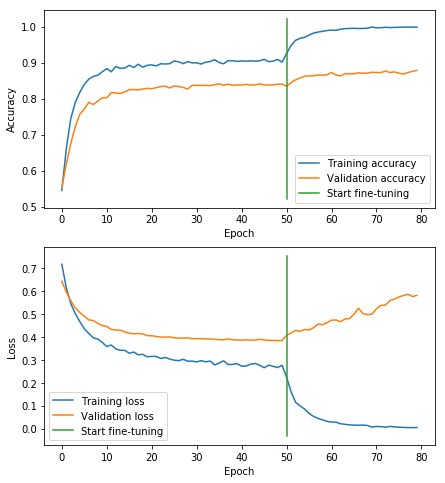

In [0]:
plt.figure(figsize=(7, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training accuracy')
plt.plot(val_acc, label='Validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot([num_epochs,num_epochs],
          plt.ylim(), label='Start fine-tuning')
plt.legend(loc='best')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training loss')
plt.plot(val_loss, label='Validation loss')
# plt.ylim([0, 1.0])
plt.plot([num_epochs,num_epochs],
         plt.ylim(), label='Start fine-tuning')
plt.legend(loc='best')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [0]:
y_true = np.array(test_labels)
y_scores = model.predict(test_ds)



def plot_predictions(dataset, num_images, y_true, y_scores, predict_correct=True):
  index = 0
  y_pred = y_scores.round().astype('int32').flatten()
  plt.figure(figsize=(16, 16))
  plt.subplots_adjust(bottom=0.05) 
  for batch in dataset.take(2):
    for i in range(num_images):
        image, true_label = batch[0][i], batch[1][i]
        
        if predict_correct:
          if true_label.numpy() == y_pred[i]:
            plt.subplot(num_images // 3, num_images // 3, index+1)
            plt.imshow(image.numpy(), cmap='Greys_r')
            plt.title('True: {} \n Predicted: {}'.format(true_label.numpy(), y_pred[i]))
            plt.grid(False) 
            index+=1
            
        else:
          if true_label.numpy() != y_pred[i]:
            plt.subplot(num_images // 3, num_images // 3, index+1)
            plt.imshow(image.numpy(), cmap='Greys_r')
            plt.title('True: {} \n Predicted: {}'.format(true_label.numpy(), y_pred[i]))
            plt.grid(False) 
            index+=1
  if predict_correct:      
    plt.savefig('./{}_{}_true_preds.pdf'.format(model_name, METHOD), format='pdf', dpi=1000)
  else:
    plt.savefig('./{}_{}_false_preds.pdf'.format(model_name, METHOD), format='pdf', dpi=1000)

          
plot_predictions(test_ds_plot, 12, y_true, y_scores, predict_correct=False)
        
     


#----from https://gist.github.com/shaypal5/94c53d765083101efc0240d776a23823-----
def plot_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):

    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, linewidths=.5, fmt="d", cmap=plt.cm.Blues)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('./{}_{}_confmat.pdf'.format(model_name, METHOD), format='pdf', dpi=1000)
    return fig
  
def plot_roc_curve(tpr, fpr, auc):
  x = np.linspace(0,1,10)
  fig = plt.figure(figsize=(10,7))
  plt.plot(x,x,':b')
  plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
  data = {'tpr':tpr,'fpr':fpr,'auc':auc}
  roc_data = pd.DataFrame(data=data)
  roc_data.to_csv('./gdrive/My Drive/{}_{}_roc.csv'.format(METHOD, model_name), index=False)
  
  roc_data.head()
  plt.plot()
  plt.legend(loc=4)
  return fig


def print_stats(y_true, y_scores):
  y_pred = y_scores.round().astype('int32').flatten()
  accuracy = accuracy_score(y_true, y_pred)
  recall = recall_score(y_true, y_pred)
  precision = precision_score(y_true, y_pred)
  f1_score = 2 * (precision * recall) / (precision + recall)
  confusion_mat = confusion_matrix(y_true, y_pred)
  tn, fp, fn, tp = confusion_mat.ravel()
  auc = roc_auc_score(y_true, y_scores).astype('float32')
  fpr, tpr, thresholds = roc_curve(y_true, y_scores, pos_label=1)

  print('True positives (1 - cancer):', tp)
  print('True negatives (0 - non_cancer):', tn)
  print('False positives:', fp)
  print('False negatives:', fn)
  print('Accuracy:', accuracy)
  print('Recall (true positive rate):', recall)
  print('Precision:', precision)
  print('F1_score:', f1_score)
  print('AUC Score:', auc)
  print('---------------------')
  print('Confusion matrix:')
  plot_confusion_matrix(confusion_mat, ['non-cancer', 'cancer'])
  plot_roc_curve(tpr,fpr,auc)
  



In [0]:
print_stats(y_true, y_scores)

In [0]:
h_inception = pd.concat([pd.read_csv('./gdrive/My Drive/holistic_inception_frozen.csv'), 
                        pd.read_csv('./gdrive/My Drive/holistic_inception_trainable.csv')])
h_inception.epoch += 1
p_inception = pd.concat([pd.read_csv('./gdrive/My Drive/patch_inception_frozen.csv'),
                         pd.read_csv('./gdrive/My Drive/patch_inception_trainable.csv')])
p_inception.epoch += 1


h_mobilenet = pd.concat([pd.read_csv('./gdrive/My Drive/holistic_mobilenet_frozen.csv'),
                         pd.read_csv('./gdrive/My Drive/holistic_mobilenet_trainable.csv')])
h_mobilenet.epoch += 1
p_mobilenet = pd.concat([pd.read_csv('./gdrive/My Drive/patch_mobilenet_frozen.csv'),
                         pd.read_csv('./gdrive/My Drive/patch_mobilenet_trainable.csv')])
p_mobilenet.epoch += 1


h_xception = pd.concat([pd.read_csv('./gdrive/My Drive/holistic_xception_frozen.csv'),
                        pd.read_csv('./gdrive/My Drive/holistic_xception_trainable.csv')])
h_xception.epoch += 1
p_xception = pd.concat([pd.read_csv('./gdrive/My Drive/patch_xception_frozen.csv'),
                        pd.read_csv('./gdrive/My Drive/patch_xception_trainable.csv')])
p_xception.epoch += 1

In [0]:
h_inception_acc = h_inception.accuracy.values
h_inception_loss = h_inception.loss.values
h_inception_val_acc = h_inception.val_accuracy.values
h_inception_val_loss = h_inception.val_loss.values

p_inception_acc = p_inception.accuracy.values
p_inception_loss = p_inception.loss.values
p_inception_val_acc = p_inception.val_accuracy.values
p_inception_val_loss = p_inception.val_loss.values


h_xception_acc = h_xception.accuracy.values
h_xception_loss = h_xception.loss.values
h_xception_val_acc = h_xception.val_accuracy.values
h_xception_val_loss = h_xception.val_loss.values

p_xception_acc = p_xception.accuracy.values
p_xception_loss = p_xception.loss.values
p_xception_val_acc = p_xception.val_accuracy.values
p_xception_val_loss = p_xception.val_loss.values


h_mobilenet_acc = h_mobilenet.accuracy.values
h_mobilenet_loss = h_mobilenet.loss.values
h_mobilenet_val_acc = h_mobilenet.val_accuracy.values
h_mobilenet_val_loss = h_mobilenet.val_loss.values

p_mobilenet_acc = p_mobilenet.accuracy.values
p_mobilenet_loss = p_mobilenet.loss.values
p_mobilenet_val_acc = p_mobilenet.val_accuracy.values
p_mobilenet_val_loss = p_mobilenet.val_loss.values




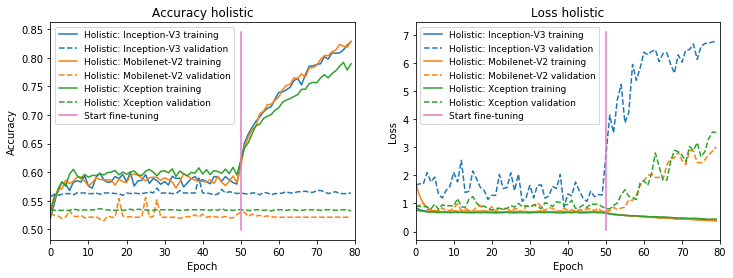

In [0]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.title('Accuracy holistic')
plt.plot(h_inception_acc, label='Holistic: Inception-V3 training', ls='-', c='C0')
plt.plot(h_inception_val_acc, label='Holistic: Inception-V3 validation', ls='--', c='C0')
plt.plot(h_mobilenet_acc, label='Holistic: Mobilenet-V2 training', ls='-', c='C1')
plt.plot(h_mobilenet_val_acc, label='Holistic: Mobilenet-V2 validation', ls='--', c='C1')
plt.plot(h_xception_acc, label='Holistic: Xception training', ls='-', c='C2')
plt.plot(h_xception_val_acc, label='Holistic: Xception validation', ls='--', c='C2')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.xlim((0,80))
plt.plot([num_epochs,num_epochs],
          plt.ylim(), label='Start fine-tuning', c='C6')
plt.legend(loc='best',prop={'size': 9})

plt.subplot(1, 2, 2)
plt.title('Loss holistic')
plt.plot(h_inception_loss, label='Holistic: Inception-V3 training', ls='-', c='C0')
plt.plot(h_inception_val_loss, label='Holistic: Inception-V3 validation', ls='--', c='C0')
plt.plot(h_mobilenet_loss, label='Holistic: Mobilenet-V2 training', ls='-', c='C1')
plt.plot(h_mobilenet_val_loss, label='Holistic: Mobilenet-V2 validation', ls='--', c='C1')
plt.plot(h_xception_loss, label='Holistic: Xception training', ls='-', c='C2')
plt.plot(h_xception_val_loss, label='Holistic: Xception validation', ls='--', c='C2')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.xlim((0,80))
plt.plot([num_epochs,num_epochs],
          plt.ylim(), label='Start fine-tuning', c='C6')
plt.legend(loc='best',prop={'size': 9})
plt.savefig('./loss-acc-holistic.pdf', format='pdf', dpi=1000)



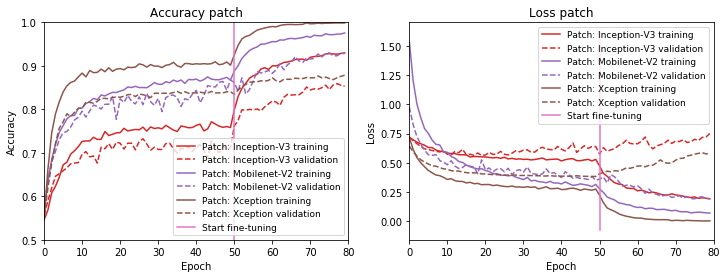

In [0]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.title('Accuracy patch')
plt.plot(p_inception_acc, label='Patch: Inception-V3 training', ls='-', c='C3')
plt.plot(p_inception_val_acc, label='Patch: Inception-V3 validation', ls='--', c='C3')
plt.plot(p_mobilenet_acc, label='Patch: Mobilenet-V2 training', ls='-', c='C4')
plt.plot(p_mobilenet_val_acc, label='Patch: Mobilenet-V2 validation', ls='--', c='C4')
plt.plot(p_xception_acc, label='Patch: Xception training', ls='-', c='C5')
plt.plot(p_xception_val_acc, label='Patch: Xception validation', ls='--', c='C5')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.xlim((0,80))
plt.ylim((0.5,1.0))
plt.plot([num_epochs,num_epochs],
          plt.ylim(), label='Start fine-tuning', c='C6')
plt.legend(loc='best',prop={'size': 9})

plt.subplot(1, 2, 2)
plt.title('Loss patch')
plt.plot(p_inception_loss, label='Patch: Inception-V3 training', ls='-', c='C3')
plt.plot(p_inception_val_loss, label='Patch: Inception-V3 validation', ls='--', c='C3')
plt.plot(p_mobilenet_loss, label='Patch: Mobilenet-V2 training', ls='-', c='C4')
plt.plot(p_mobilenet_val_loss, label='Patch: Mobilenet-V2 validation', ls='--', c='C4')
plt.plot(p_xception_loss, label='Patch: Xception training', ls='-', c='C5')
plt.plot(p_xception_val_loss, label='Patch: Xception validation', ls='--', c='C5')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.xlim((0,80))
plt.plot([num_epochs,num_epochs],
          plt.ylim(), label='Start fine-tuning', c='C6')
plt.legend(loc='best', prop={'size': 9})
plt.savefig('./loss-acc-patch.pdf', format='pdf', dpi=1000)



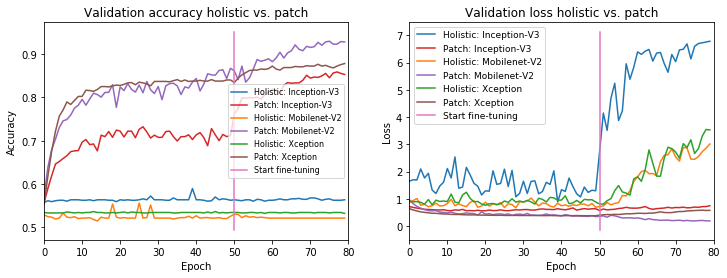

In [0]:
plt.figure(figsize=(12, 4))
plt.subplot(1,2,1)
plt.title('Validation accuracy holistic vs. patch')
plt.plot(h_inception_val_acc, label='Holistic: Inception-V3', ls='-',c='C0')
plt.plot(p_inception_val_acc, label='Patch: Inception-V3', ls='-',c='C3')
plt.plot(h_mobilenet_val_acc, label='Holistic: Mobilenet-V2', ls='-',c='C1')
plt.plot(p_mobilenet_val_acc, label='Patch: Mobilenet-V2', ls='-',c='C4')
plt.plot(h_xception_val_acc, label='Holistic: Xception', ls='-',c='C2')
plt.plot(p_xception_val_acc, label='Patch: Xception', ls='-', c='C5')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.xlim((0,80))
plt.plot([num_epochs,num_epochs],
          plt.ylim(), label='Start fine-tuning',c='C6')
plt.legend(loc='best',prop={'size': 8})

plt.subplot(1,2,2)
plt.title('Validation loss holistic vs. patch')
plt.plot(h_inception_val_loss, label='Holistic: Inception-V3', ls='-',c='C0')
plt.plot(p_inception_val_loss, label='Patch: Inception-V3', ls='-',c='C3')
plt.plot(h_mobilenet_val_loss, label='Holistic: Mobilenet-V2', ls='-',c='C1')
plt.plot(p_mobilenet_val_loss, label='Patch: Mobilenet-V2', ls='-',c='C4')
plt.plot(h_xception_val_loss, label='Holistic: Xception', ls='-',c='C2')
plt.plot(p_xception_val_loss, label='Patch: Xception', ls='-', c='C5')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.xlim((0,80))
plt.plot([num_epochs,num_epochs],
          plt.ylim(), label='Start fine-tuning',c='C6')
plt.legend(loc='best',prop={'size': 9})
plt.savefig('./val_loss-acc-holistic-vs-patch.pdf', format='pdf', dpi=1000)


In [0]:
h_inception_roc = pd.read_csv('./gdrive/My Drive/holistic_inception_roc.csv')
# h_inception_auc = h_inception_roc.auc.values[0]
# h_inception_roc = h_inception_roc.drop(['auc'], axis=1)

p_inception_roc = pd.read_csv('./gdrive/My Drive/patch_inception_roc.csv')
# p_inception_auc = p_inception_roc.auc.values[0]
# p_inception_roc = p_inception_roc.drop(['auc'], axis=1)

h_mobilenet_roc = pd.read_csv('./gdrive/My Drive/holistic_mobilenet_roc.csv')
# h_mobilenet_auc = h_mobilenet_roc.auc.values[0]
# h_mobilenet_roc = h_mobilenet_roc.drop(['auc'], axis=1)

p_mobilenet_roc = pd.read_csv('./gdrive/My Drive/patch_mobilenet_roc.csv')
# p_mobilenet_auc = p_mobilenet_roc.auc.values[0]
# p_mobilenet_roc = p_mobilenet_roc.drop(['auc'], axis=1)

h_xception_roc = pd.read_csv('./gdrive/My Drive/holistic_xception_roc.csv')
# h_xception_auc = h_xception_roc.auc.values[0]
# h_xception_roc = h_xception_roc.drop(['auc'], axis=1)

p_xception_roc = pd.read_csv('./gdrive/My Drive/patch_xception_roc.csv')
# p_xception_auc = p_xception_roc.auc.values[0]
# p_xception_roc = p_xception_roc.drop(['auc'], axis=1)

h_inception_tpr = h_inception_roc.tpr.values
h_inception_fpr = h_inception_roc.fpr.values
h_inception_auc = h_inception_roc.auc.values[0]
p_inception_tpr = p_inception_roc.tpr.values
p_inception_fpr = p_inception_roc.fpr.values
p_inception_auc = p_inception_roc.auc.values[0]

h_xception_tpr = h_xception_roc.tpr.values
h_xception_fpr = h_xception_roc.fpr.values
h_xception_auc = h_xception_roc.auc.values[0]
p_xception_tpr = p_xception_roc.tpr.values
p_xception_fpr = p_xception_roc.fpr.values
p_xception_auc = p_xception_roc.auc.values[0]

h_mobilenet_tpr = h_mobilenet_roc.tpr.values
h_mobilenet_fpr = h_mobilenet_roc.fpr.values
h_mobilenet_auc = h_mobilenet_roc.auc.values[0]
p_mobilenet_tpr = p_mobilenet_roc.tpr.values
p_mobilenet_fpr = p_mobilenet_roc.fpr.values
p_mobilenet_auc = p_mobilenet_roc.auc.values[0]

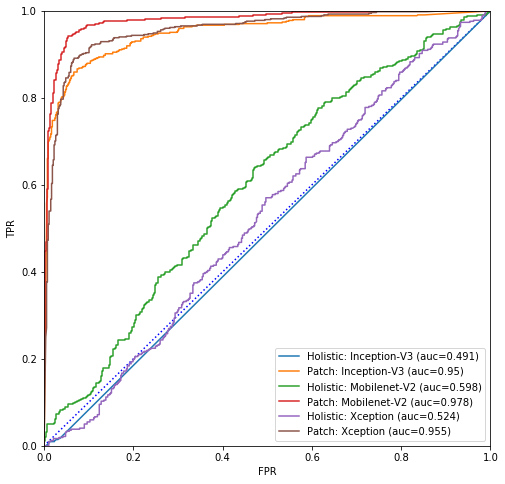

In [0]:
plt.figure(figsize=(8,8))

x = np.linspace(0,1,10)
plt.plot(x,x,':b')

plt.plot(h_inception_fpr,h_inception_tpr,label="Holistic: Inception-V3 (auc="+str(round(h_inception_auc,3)) + ")")
plt.plot(p_inception_fpr,p_inception_tpr,label="Patch: Inception-V3 (auc="+str(round(p_inception_auc,3)) + ")")

plt.plot(h_mobilenet_fpr,h_mobilenet_tpr,label="Holistic: Mobilenet-V2 (auc="+str(round(h_mobilenet_auc,3)) + ")")
plt.plot(p_mobilenet_fpr,p_mobilenet_tpr,label="Patch: Mobilenet-V2 (auc="+str(round(p_mobilenet_auc,3)) + ")")

plt.plot(h_xception_fpr,h_xception_tpr,label="Holistic: Xception (auc="+str(round(h_xception_auc,3)) + ")")
plt.plot(p_xception_fpr,p_xception_tpr,label="Patch: Xception (auc="+str(round(p_xception_auc,3)) + ")")

plt.ylabel('TPR')
plt.xlabel('FPR')
plt.xlim((0,1.0))
plt.ylim((0,1.0))
plt.legend(loc='best',prop={'size': 10})
plt.savefig('./roc-holistic-vs-patch.pdf', format='pdf', dpi=1000)




In [0]:
round(0.49085787,3)

0.491